In [121]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import re
from selenium import webdriver

import random
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [29]:
def getHtml(url):
    driver = webdriver.Edge(executable_path = 'C:\\Users\\Home\\Documents\\msedgedriver.exe') # используем Selenium
    driver.get(url)
    
    try:
        lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        match=False
        for j in range(500):
            lastCount = lenOfPage
            delay = random.randint(10, 30) / 10
            time.sleep(delay)
            lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")

    except Exception as e:
        print(e)

    time.sleep(1)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    driver.close()
    rows = soup.find('div', id="search_resultsRows")
    return rows

In [37]:
def getData(href):
    labels = []
    temp = requests.post(href)
    soup = BeautifulSoup(temp.text, 'html.parser')
    
    try:
        page = soup.find('div', class_="glance_tags_ctn popular_tags_ctn")
        for label in page.find_all('a'):
            labels.append(label.text.split('\t\t\t\t\t\t\t\t\t\t\t\t')[1])
    except:
        pass
    return labels

In [139]:
def getRows(game_type, page):
    result = []
    i = 0
    
    for game in page.find_all('a'):
        i += 1
        if i > 6000:
            return result
        else:
            try:

                href = game.attrs.get('href')
                
                #review_data = game.find('span', "data-tooltip-html")
                review_data = game.find('span', class_=re.compile('search_review_summary')).attrs.get('data-tooltip-html').split('<br>')
                
                title = game.find('span', class_="title").text
                price = float(game.find('div', class_="col search_price_discount_combined responsive_secondrow").attrs.get('data-price-final'))
                release_date = game.find('div', class_="col search_released responsive_secondrow").text
                review_type = review_data[0]
                rating = review_data[1].split(' ')[0]
                review_count = review_data[1].split(' ')[3]
                labels = getData(href)
                
                result.append([title, price, labels, game_type, release_date, review_type, rating, review_count])

            except Exception as e:
                #print(e)
                pass
                    
    #return result

## Сделаем запрос по тегу "Инди":

In [32]:
indie_page = getHtml('https://store.steampowered.com/search/?tags=492&category1=998')

In [135]:
indie_games = getRows("indie", indie_page)

'NoneType' object has no attribute 'attrs'


In [126]:
indie_games1 = getRows("indie", indie_page)

In [129]:
df1 = pd.DataFrame(indie_games1)


## Затем запрос, исключающий этот тег:

In [39]:
AAA_page = getHtml('https://store.steampowered.com/search/?untags=492&category1=998')

In [140]:
AAA_games = getRows("AAA", AAA_page)

# Сформируем таблицу в pandas

In [141]:
cols = ['Название', 'Цена', 'Метки', 'Тип', 'Дата выхода', 'Отзывы', 'Рейтинг', 'Число отзывов']

all_games = indie_games + AAA_games
df = pd.DataFrame(all_games, columns=cols)

In [142]:
df

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Rust,300000.0,"[Survival, Crafting, Multiplayer, Open World, ...",indie,"8 Feb, 2018",Very Positive,87%,"620,100"
1,Phasmophobia,30900.0,"[Horror, Online Co-Op, Multiplayer, Psychologi...",indie,"18 Sep, 2020",Overwhelmingly Positive,97%,"339,164"
2,DayZ,119900.0,"[Survival, Zombies, Multiplayer, Open World, A...",indie,"13 Dec, 2018",Mostly Positive,71%,"249,326"
3,Risk of Rain 2,79900.0,"[Third-Person Shooter, Action Roguelike, Multi...",indie,"11 Aug, 2020",Overwhelmingly Positive,96%,"130,322"
4,Project Zomboid,43500.0,"[Survival, Zombies, Open World, Open World Sur...",indie,"8 Nov, 2013",Very Positive,92%,"69,375"
...,...,...,...,...,...,...,...,...
11989,Corridor 7: Alien Invasion,25900.0,"[Retro, Aliens, FPS, Shooter, Pixel Graphics, ...",AAA,"6 Aug, 2021",Positive,100%,11
11990,V696,12000.0,"[First-Person, Psychological Horror, Thriller,...",AAA,"11 Jan, 2022",Mixed,56%,32
11991,Moorhuhn / Crazy Chicken Tales,6100.0,"[Casual, 3D Platformer]",AAA,"30 Sep, 2014",Mixed,63%,30
11992,Must Dash Amigos,17500.0,"[Combat Racing, PvP, Racing, Difficult, Arcade...",AAA,"23 Jul, 2019",Mostly Positive,76%,17


## Устраним пустоты в полученных данных 

In [143]:
df = df.convert_dtypes()
df['Цена'] = df['Цена'].astype(float)
df['Цена'] = df['Цена'] / 100

In [144]:
d1 = pd.to_datetime(df['Дата выхода'], format="%d %b, %Y", errors='coerce')
d2 = pd.to_datetime(df['Дата выхода'], format="%b %Y", errors='coerce')

df['Дата выхода'] = d1.combine_first(d2)

In [145]:
df

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Rust,3000.0,"[Survival, Crafting, Multiplayer, Open World, ...",indie,2018-02-08,Very Positive,87%,"620,100"
1,Phasmophobia,309.0,"[Horror, Online Co-Op, Multiplayer, Psychologi...",indie,2020-09-18,Overwhelmingly Positive,97%,"339,164"
2,DayZ,1199.0,"[Survival, Zombies, Multiplayer, Open World, A...",indie,2018-12-13,Mostly Positive,71%,"249,326"
3,Risk of Rain 2,799.0,"[Third-Person Shooter, Action Roguelike, Multi...",indie,2020-08-11,Overwhelmingly Positive,96%,"130,322"
4,Project Zomboid,435.0,"[Survival, Zombies, Open World, Open World Sur...",indie,2013-11-08,Very Positive,92%,"69,375"
...,...,...,...,...,...,...,...,...
11989,Corridor 7: Alien Invasion,259.0,"[Retro, Aliens, FPS, Shooter, Pixel Graphics, ...",AAA,2021-08-06,Positive,100%,11
11990,V696,120.0,"[First-Person, Psychological Horror, Thriller,...",AAA,2022-01-11,Mixed,56%,32
11991,Moorhuhn / Crazy Chicken Tales,61.0,"[Casual, 3D Platformer]",AAA,2014-09-30,Mixed,63%,30
11992,Must Dash Amigos,175.0,"[Combat Racing, PvP, Racing, Difficult, Arcade...",AAA,2019-07-23,Mostly Positive,76%,17


## Анализируем данные

### 1. Распределение по типам

([<matplotlib.patches.Wedge at 0x151f6055220>,
 [Text(-0.0005763288394711897, 1.0999998490204757, 'indie'),
  Text(0.0005764318288901206, -1.099999848966511, 'AAA')],
 [Text(-0.0003143611851661034, 0.599999917647532, '50%'),
  Text(0.000314417361212793, -0.5999999176180968, '50%')])

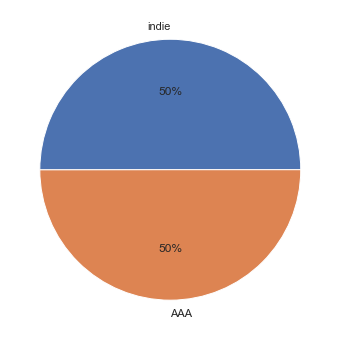

In [146]:
plt.pie(df['Тип'].value_counts(), labels = df['Тип'].unique(), autopct='%.0f%%')

## 1. Цены

### 1.1 Средняя цена игры

In [163]:
df[['Цена']].apply(np.median)

Цена    249.0
dtype: float64

In [164]:
df[df['Тип'] == 'indie'][['Цена']].apply(np.median)

Цена    249.0
dtype: float64

In [165]:
df[df['Тип'] == 'AAA'][['Цена']].apply(np.median)

Цена    259.0
dtype: float64

### 1.2. Зависимость между типом и ценой

Text(0.5, 1.0, 'Зависимость между типом и ценой')

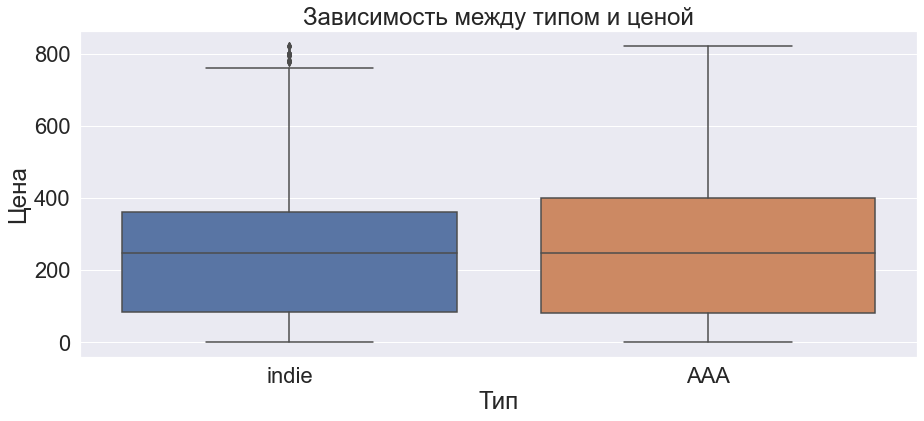

In [252]:
sns.set(font_scale=2)
sns.boxplot(x ='Тип', y ='Цена', data = df.loc[df['Цена']<df['Цена'].quantile(0.95)]).set_title('Зависимость между типом и ценой')

### 1.3 Самые дорогие игры 

In [167]:
df.sort_values(by = 'Цена', ascending = False).head(10)

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
10584,Mosaic: Game of Gods,99999.00,"[Casual, Puzzle, God Game]",AAA,2016-10-31,Very Positive,94%,54
2529,The Orphan Dreams,9999.00,"[Adventure, Casual, Indie, RPG]",indie,2016-04-27,Mostly Positive,78%,19
4237,Yandere School,6666.00,"[Anime, Action, Indie, Sexual Content, Violent...",indie,2017-09-01,Mixed,61%,273
10935,ROMANCE OF THE THREE KINGDOMS XIV: Diplomacy a...,5439.00,[],AAA,2020-12-10,Mixed,57%,"9,670"
746,RealFlight 9.5S,5098.32,"[Simulation, Indie, Racing, Flight, VR]",indie,2021-12-07,Very Positive,80%,338
7430,A-Train: All Aboard! Tourism,4499.00,"[Simulation, Trains, Immersive Sim, City Build...",AAA,2021-12-08,Mostly Positive,70%,72
8175,Re:ZERO -Starting Life in Another World- The P...,4198.00,"[Adventure, Anime, Visual Novel, Strategy, Tur...",AAA,2021-01-28,Very Positive,87%,377
6000,ELDEN RING,3999.00,"[Souls-like, Relaxing, Dark Fantasy, RPG, Diff...",AAA,2022-02-24,Very Positive,89%,"323,118"
7184,Ys IX -Monstrum NOX-,3929.00,"[Action, RPG, JRPG, Action RPG, 3D, Anime, Dar...",AAA,2022-01-19,Very Positive,89%,69
7436,ROMANCE OF THE THREE KINGDOMS XIV: Diplomacy a...,3739.00,[],AAA,2020-12-10,Mixed,57%,"9,602"


## 2. Отзывы

### 2.1 Общая статистика

In [168]:
df['Отзывы'].value_counts()

Very Positive              6012
Mostly Positive            2034
Positive                   1629
Mixed                      1605
Overwhelmingly Positive     707
Mostly Negative               5
Overwhelmingly Negative       2
Name: Отзывы, dtype: Int64

<AxesSubplot:xlabel='Отзывы', ylabel='count'>

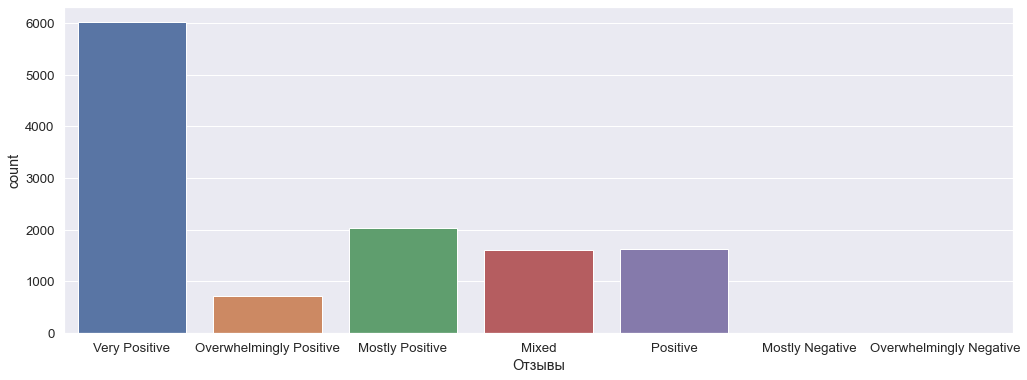

In [261]:
sns.set(font_scale=1.2, rc={'figure.figsize':(1,6)})
sns.countplot(df['Отзывы'])

### 2.2 Самый высокий рейтинг

In [229]:
df1 = df.copy()
df1[df1['Рейтинг'] == '100%']

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
1091,The Last Cube,435.0,"[3D Platformer, Puzzle Platformer, Puzzle, Dif...",indie,2022-03-10,Very Positive,100%,54
1255,Cleo - a pirate's tale,180.0,"[Adventure, Pirates, Pixel Graphics, 2D, Top-D...",indie,2021-12-12,Very Positive,100%,219
1653,Tentacular,699.0,"[Casual, VR, Funny, Building, Puzzle, Action, ...",indie,2022-03-24,Positive,100%,10
1781,FIND ALL 2: Middle Ages,66.0,"[Hidden Object, Casual, Hand-drawn, Colorful, ...",indie,2022-03-03,Positive,100%,33
1859,Distant Memoraĵo,435.0,"[Adventure, Education, Visual Novel, Anime, Cu...",indie,2021-07-16,Very Positive,100%,79
...,...,...,...,...,...,...,...,...
11943,Dark Parables: The Final Cinderella Collector'...,249.0,"[Casual, Adventure, Hidden Object]",AAA,2016-06-17,Positive,100%,19
11948,LOVE 3,259.0,"[Precision Platformer, Exploration, Minimalist...",AAA,2021-12-07,Positive,100%,42
11964,Mahjong Solitaire Refresh,435.0,"[Casual, Puzzle]",AAA,2019-09-12,Positive,100%,10
11980,Castle on the Coast,515.0,"[3D Platformer, Collectathon, Retro, Cute, Old...",AAA,2021-12-02,Positive,100%,14


In [230]:
df1['Рейтинг'] = (df1['Рейтинг'].str.split('%').str[0]).astype(float)

Text(0.5, 1.0, 'Распределение рейтинга')

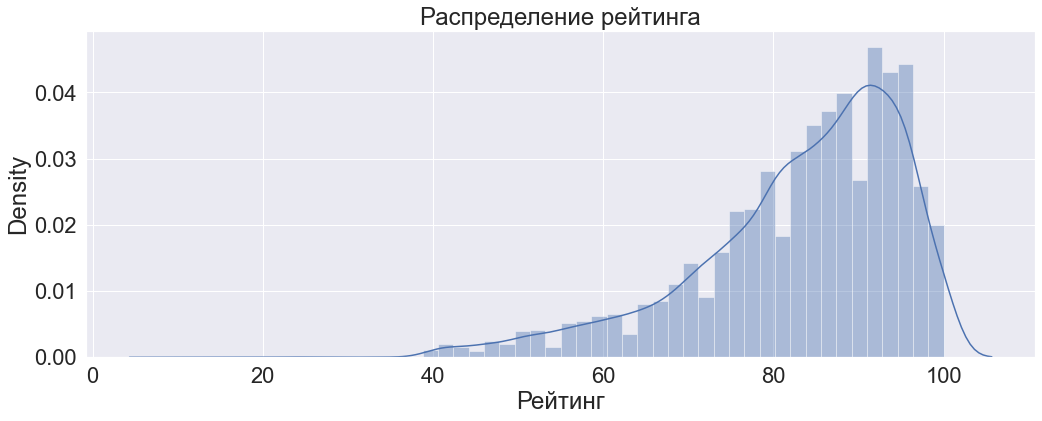

In [266]:
sns.set(font_scale=2)
sns.distplot(df1['Рейтинг']).set_title('Распределение рейтинга')

### 2.3 А что будет, если посчитаем рейтинг только тех игр, у которых больше 1000 отзывов?

In [248]:
df_1000_review = df1.copy()
df_1000_review['Число отзывов'] = df_1000_review['Число отзывов'].replace(to_replace =',', value = '', regex = True).astype(int)
df_1000_review = df_1000_review[df_1000_review['Число отзывов'] > 1000]
df_1000_review

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Rust,3000.0,"[Survival, Crafting, Multiplayer, Open World, ...",indie,2018-02-08,Very Positive,87.0,620100
1,Phasmophobia,309.0,"[Horror, Online Co-Op, Multiplayer, Psychologi...",indie,2020-09-18,Overwhelmingly Positive,97.0,339164
2,DayZ,1199.0,"[Survival, Zombies, Multiplayer, Open World, A...",indie,2018-12-13,Mostly Positive,71.0,249326
3,Risk of Rain 2,799.0,"[Third-Person Shooter, Action Roguelike, Multi...",indie,2020-08-11,Overwhelmingly Positive,96.0,130322
4,Project Zomboid,435.0,"[Survival, Zombies, Open World, Open World Sur...",indie,2013-11-08,Very Positive,92.0,69375
...,...,...,...,...,...,...,...,...
11930,Nine to Five,0.0,"[Free to Play, FPS, Multiplayer, Team-Based, T...",AAA,2021-08-26,Mixed,46.0,2737
11934,Bloodline Champions,0.0,"[Free to Play, Action, MOBA, Multiplayer, PvP,...",AAA,2011-10-28,Very Positive,85.0,1646
11941,Disturbed,0.0,"[Free to Play, Horror, Adventure, Visual Novel...",AAA,2016-10-03,Very Positive,92.0,1638
11958,Flatout Complete Pack,599.0,[],AAA,2011-12-13,Very Positive,83.0,19612


In [250]:
df_1000_review[df_1000_review['Рейтинг'] > 98]

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
1074,A Short Hike,195.0,"[Adventure, Exploration, Indie, Cute, Relaxing...",indie,2019-07-30,Overwhelmingly Positive,99.0,8465
4335,Aventura Copilului Albastru și Urât,61.0,"[Adventure, Hentai, Sexual Content, 2D, Gore, ...",indie,2021-02-08,Overwhelmingly Positive,99.0,1815
6207,ULTRAKILL,435.0,"[Early Access, FPS, Arena Shooter, Spectacle f...",AAA,2020-09-03,Overwhelmingly Positive,99.0,20348
6408,Senren＊Banka,899.0,"[Casual, Adventure, Visual Novel, Anime, Datin...",AAA,2020-02-14,Overwhelmingly Positive,99.0,7899
6665,Sucker for Love: First Date,259.0,"[Visual Novel, Romance, Dating Sim, RPG, Point...",AAA,2022-01-20,Overwhelmingly Positive,99.0,1133
6784,Maitetsu:Last Run!!,1459.0,"[Sexual Content, Casual, Visual Novel, Anime, ...",AAA,2020-10-30,Overwhelmingly Positive,99.0,1587
11380,Project Kat - Paper Lily Prologue,0.0,"[Anime, Psychological Horror, Pixel Graphics, ...",AAA,2021-10-16,Overwhelmingly Positive,99.0,2523


### 2.4 Зависимость между типом и отзывами

<AxesSubplot:xlabel='Отзывы', ylabel='count'>

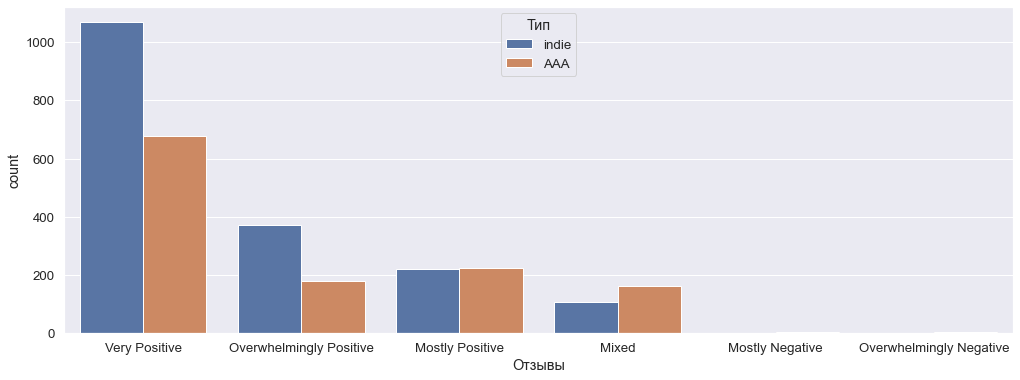

In [262]:
sns.countplot(x='Отзывы', hue='Тип', data = df_1000_review)

## 3. Метки

### 3.1 Инди-игры и пиксельная графика — одно и тоже?

In [197]:
df3 = pd.DataFrame()

for idx in df.index:
    if 'Pixel Graphics' in df['Метки'][idx]:
        df3 = df3.append(df.loc[idx])
df3

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
12,Vampire Survivors,82.0,"[Action Roguelike, Pixel Graphics, Bullet Hell...",indie,2021-12-17,Overwhelmingly Positive,98%,"69,258"
20,Stardew Valley,299.0,"[Farming Sim, Life Sim, Pixel Graphics, RPG, M...",indie,2016-02-26,Overwhelmingly Positive,98%,"381,759"
22,The Binding of Isaac: Rebirth,449.0,"[Action Roguelike, Roguelike, Indie, Replay Va...",indie,2014-11-04,Overwhelmingly Positive,97%,"173,139"
23,Terraria,610.0,"[Open World Survival Craft, Sandbox, Survival,...",indie,2011-05-16,Overwhelmingly Positive,98%,"745,437"
25,Dead Cells,499.0,"[Roguelite, Roguelike, Pixel Graphics, Difficu...",indie,2018-08-06,Overwhelmingly Positive,97%,"89,135"
...,...,...,...,...,...,...,...,...
11951,The Sundew,360.0,"[Adventure, Point & Click, Story Rich, Choices...",AAA,2021-10-14,Positive,90%,32
11967,Yukie: A Japanese Winter Fairy Tale,79.0,"[Side Scroller, Visual Novel, JRPG, 2D, Surrea...",AAA,2017-07-14,Mostly Positive,72%,25
11968,Black Widow: Recharged,809.0,"[Action, Arcade, Shooter, Shoot 'Em Up, Twin S...",AAA,2021-10-28,Positive,91%,12
11973,Rotten Tide,154.0,"[Action, Strategy, Tower Defense, Zombies, Sim...",AAA,2021-03-04,Mostly Positive,70%,10


Text(0.5, 1.0, 'Количество игр с тегом "Пиксельная графика"')

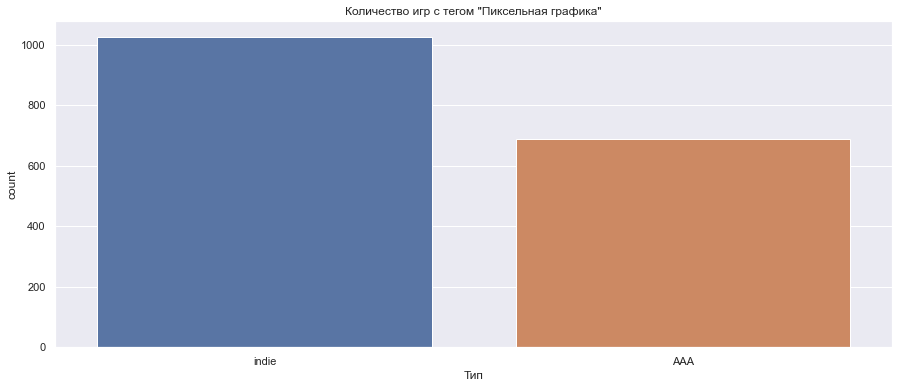

In [200]:
sns.countplot(df3['Тип']).set_title('Количество игр с тегом \"Пиксельная графика\Ы"')